In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
def dmixture_logpdf(x, mus, sigmas, ws):
    # Compute log normal density for each component
    log_normal = -0.5 * torch.log(2 * np.pi * sigmas**2) - 0.5 * ((x - mus)**2) / (sigmas**2)

    # Compute weighted exponential of log densities
    weighted_exp = ws * torch.exp(log_normal)

    # Sum for normalization
    total = torch.sum(weighted_exp)

    # Compute normalized weights
    normalized_weights = weighted_exp / total

    # Compute score for each component: -(x - μ)/(σ²)
    component_scores = -(x - mus) / (sigmas**2)

    # Weight and sum the component scores
    return torch.sum(normalized_weights * component_scores)

class MixtureGaussian(nn.Module):
    """Mixture Gaussian score function."""

    def __init__(self, mus, log_sigmas, ws):
        super().__init__()

        # Convert inputs to tensors if they aren't already
        self.mus = torch.as_tensor(mus, dtype=torch.float32)
        self.log_sigmas = torch.as_tensor(log_sigmas, dtype=torch.float32)
        self.ws = torch.as_tensor(ws, dtype=torch.float32)

        # Check that mus, log_sigmas, and ws are of the same length
        lengths = set(map(len, [self.mus, self.log_sigmas, self.ws]))
        if len(lengths) != 1:
            raise ValueError(
                "`mus`, `log_sigmas` and `ws` must all be of the same length!"
            )

        # Register tensors as buffers
        self.register_buffer('mus_buffer', self.mus)
        self.register_buffer('log_sigmas_buffer', self.log_sigmas)
        self.register_buffer('ws_buffer', self.ws)

    def forward(self, x):
        """Forward pass.
        """
        # Ensure x is 2D
        if x.dim() == 1:
            x = x.unsqueeze(-1)

        # Compute score using dmixture_logpdf
        scores = []
        for xi in x:
            score = dmixture_logpdf(
                xi,
                self.mus,
                torch.exp(self.log_sigmas),
                self.ws
            )
            scores.append(score)

        return torch.stack(scores)

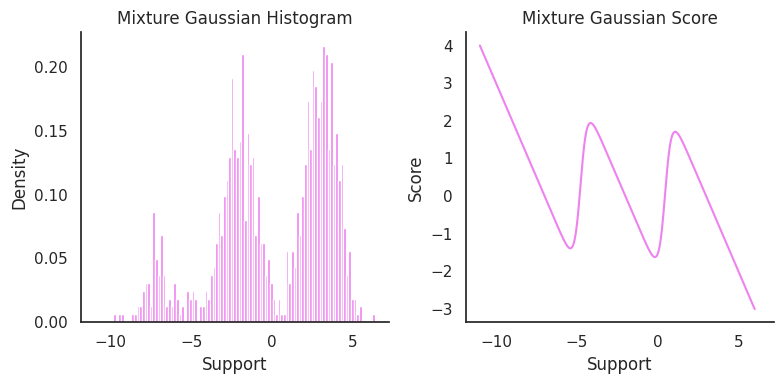

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(91)

# Define parameters
mus = torch.tensor([-7, -2, 3])
sigmas = torch.ones(3)
ws = torch.tensor([0.1, 0.4, 0.5])

# Create figure
fig, axes = plt.subplots(figsize=(8, 4), ncols=2, sharex=True)

# First subplot: Generate mixture data and plot histogram
plt.sca(axes[0])

# Generate data from each mixture component
mix1 = torch.randn(100) * sigmas[0] + mus[0]  # Using defined parameters
mix2 = torch.randn(400) * sigmas[1] + mus[1]
mix3 = torch.randn(500) * sigmas[2] + mus[2]

# Combine data
data = torch.cat([mix1, mix2, mix3]).reshape(-1, 1)
plt.hist(data.numpy(), bins=100, density=True,color='violet')
#plt.hist(data.numpy(), bins=100, )
plt.xlabel("Support")
plt.ylabel("Density")
plt.title("Mixture Gaussian Histogram")
sns.despine()

# Second subplot: Plot mixture Gaussian score
plt.sca(axes[1])

# Create evaluation points
x = torch.linspace(-11, 6, 1000)

# Initialize mixture model
three_comp_gaussian = MixtureGaussian(mus, torch.log(sigmas), ws)

# Compute scores for all points using vectorized operations
mixture_logpdf_grads = three_comp_gaussian(x)

plt.plot(x.numpy(), mixture_logpdf_grads.numpy(), color='violet')
plt.xlabel("Support")
plt.ylabel("Score")
plt.title("Mixture Gaussian Score")
sns.despine()
plt.savefig("mixture_gaussian_plot.svg", format="svg")
plt.tight_layout()